# Unbalanced Cell Type Alignment

```{note}
This notebook is a sample of what our applications chapter will look like when we release it. We're working hard on compiling all of our results to share with you!
```

In this notebook, we'll look at what happens when we systematically downsample one of our domains in an alignment problem (simulating a situtation where we only have separately assayed data). In particular, we'll systematically downsample by cell type in a PBMC co-assayed dataset that contains RNAseq (gene expression) and ATACseq (open chromatin) data.

### Preprocessing

We can begin by loading in our data:

In [4]:
import pickle
import scanpy as sc
rna = pickle.load(open('./data/PBMC/rna_50pca_50topics.pkl', 'rb'))
atac = pickle.load(open('./data/PBMC/atac_50pca_50topics.pkl', 'rb'))
adata = sc.read_h5ad('./data/PBMC/adata.h5ad')

We can name our data and look at its shape:

In [5]:
import pandas as pd
atac.columns = ["Region {0}".format(i + 1) for i in range(50)]
rna.columns = ["Gene {0}".format(i + 1) for i in range(50)]
rna.shape, atac.shape

((2407, 50), (2407, 50))

We can additionally look at the cell types present:

In [7]:
ctypes = adata.obs['celltype']
ctypes = pd.Series(ctypes).loc[atac.index]
ctypes

CCAAGTTAGTAACCAC-1      CD14+ Monocytes
GTGCTTACAGTAATAG-1      CD14+ Monocytes
AGTCTTGCACAAAGAC-1    FCGR3A+ Monocytes
CTTTATGGTAAGCACC-1          CD4 T cells
CAATCGCCACTTCACT-1          CD4 T cells
                            ...        
CCGGTAGGTCGTTACT-1          CD4 T cells
CTAAATGTCTATTGTC-1          CD4 T cells
CCGCACACACTTCACT-1      CD14+ Monocytes
AATGCAACACCACAAC-1          CD4 T cells
CAAGGTTTCCCTGACT-1          CD4 T cells
Name: celltype, Length: 2407, dtype: category
Categories (7, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells']

In [8]:
rna = pd.concat((rna, ctypes), axis=1)
atac = pd.concat((atac, ctypes), axis=1)

In [9]:
from collections import Counter
Counter(rna['celltype'])
Counter(atac['celltype'])

Counter({'CD4 T cells': 1114,
         'CD14+ Monocytes': 648,
         'CD8 T cells': 207,
         'B cells': 201,
         'FCGR3A+ Monocytes': 109,
         'NK cells': 84,
         'Dendritic cells': 44})

From here, we can randomly sample fractions of each cell type to keep in the ATACseq domain:

In [29]:
import random

random.seed(1)
dfs = []
fracs = {}
for ctype, df in atac.groupby("celltype", observed=True):
    print(ctype)
    fracs[df["celltype"].iloc[0]] = 0.5 + 0.05*random.choice(range(0, 11, 1))
    dfs.append(df.sample(frac=fracs[df["celltype"].iloc[0]], random_state=10))
atac_mod = pd.concat((dfs), axis=0)
Counter(atac_mod['celltype'])

B cells
CD4 T cells
CD8 T cells
CD14+ Monocytes
Dendritic cells
FCGR3A+ Monocytes
NK cells


Counter({'CD4 T cells': 891,
         'CD14+ Monocytes': 454,
         'B cells': 161,
         'CD8 T cells': 104,
         'FCGR3A+ Monocytes': 93,
         'NK cells': 67,
         'Dendritic cells': 40})

In [30]:
# retrieving numeric matrices
atac_mtx = atac_mod.iloc[:, :-1]
rna_mtx = rna.iloc[:, :-1]

Note that we can easily view the manner in which we downsampled our data:

In [31]:
fracs

{'B cells': 0.8,
 'CD4 T cells': 0.8,
 'CD8 T cells': 0.5,
 'CD14+ Monocytes': 0.7,
 'Dendritic cells': 0.9,
 'FCGR3A+ Monocytes': 0.8500000000000001,
 'NK cells': 0.8}

### Alignment

Now, we can begin our usual AGW workflow:

In [32]:
from scotplus.solvers import SinkhornSolver
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

As usual, we normalize our data:

In [33]:
rna_mtx=normalize(rna_mtx)
atac_mtx=normalize(atac_mtx)

And visualize it in two dimensions before alignment:

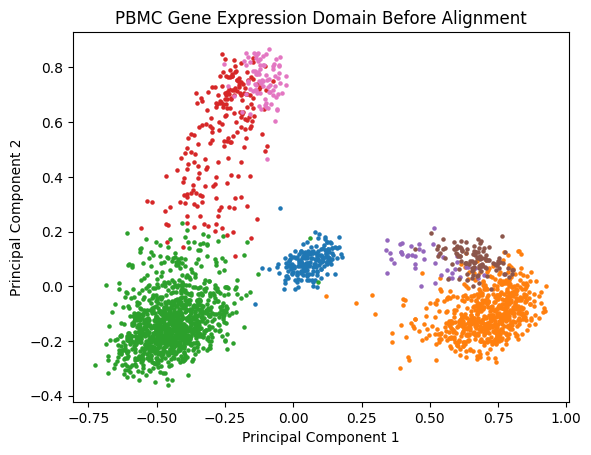

In [35]:
import numpy as np

# Sample label array (replace with your own label array)
label_array = np.array(rna['celltype'].to_list())

# Get unique labels
unique_labels = np.unique(label_array)
pca=PCA(n_components=2)
Xrna_2Dpca=pca.fit_transform(rna_mtx)
# Plot PCA-transformed data with labels
plt.figure()

# Plot each unique label separately
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Xrna_2Dpca[mask, 0], Xrna_2Dpca[mask, 1], s=5, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

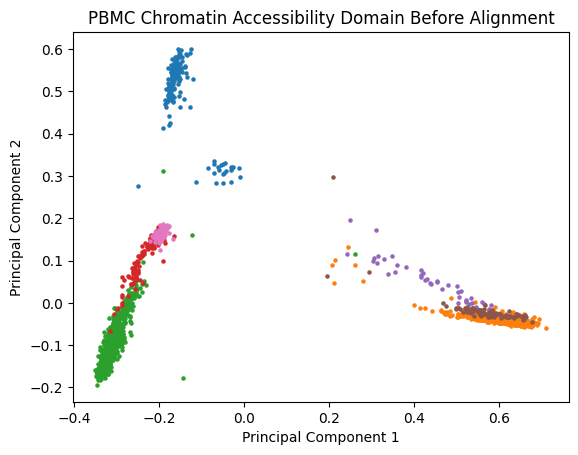

In [37]:
import numpy as np

# Sample label array (replace with your own label array)
label_array = np.array(atac_mod['celltype'].to_list())

# Get unique labels
unique_labels = np.unique(label_array)
pca=PCA(n_components=2)
Yatac_2Dpca=pca.fit_transform(atac_mtx)
# Plot PCA-transformed data with labels
plt.figure()

# Plot each unique label separately
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yatac_2Dpca[mask, 0], Yatac_2Dpca[mask, 1], s=5, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We can now attempt an alignment:

In [58]:
from scotplus.utils.alignment import compute_graph_distances

Drna = compute_graph_distances(rna_mtx, n_neighbors=25, mode='connectivity')
Datac =compute_graph_distances(atac_mtx, n_neighbors=25, mode='connectivity')
agw_class =  SinkhornSolver(tol_uot=2e-5)
pi_samp,_,pi_feat = agw_class.ugw(torch.from_numpy(Drna).to(device), torch.from_numpy(Datac).to(device), rho = (0.1,0.1), eps = 1e-3, verbose = False)


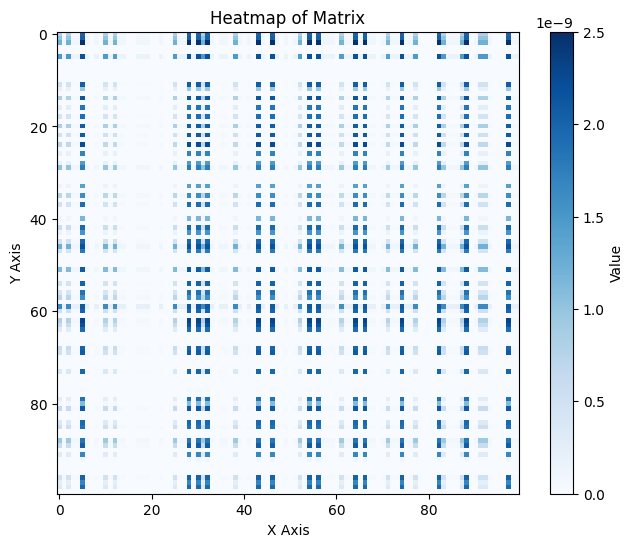

In [60]:
# Plot a corner of the heatmap to get a sense for density
plt.figure(figsize=(8, 6))
plt.imshow(pi_samp[0:100,0:100], cmap='Blues', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap of Matrix')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()

Now, we can finally compute our alignment:

In [61]:
from scotplus.utils.alignment import get_barycentre
aligned_atac = get_barycentre(rna_mtx, np.transpose(pi_samp))
rna_mtx.shape, aligned_atac.shape

((2407, 50), torch.Size([1810, 50]))

### Evaluation

We can begin by visualizing the aligned data on its own, as well as in conjunction with the original RNAseq data:

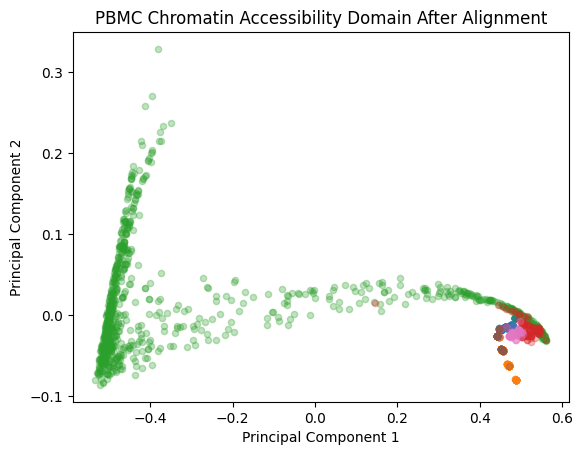

In [63]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
# run PC jointly:
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=pca.fit_transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['celltype'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_pc = np.concatenate((Xrna_integrated_pc,Yatac_subsamp_integrated_pc), axis=0)
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yatac_subsamp_integrated_pc[mask, 0], Yatac_subsamp_integrated_pc[mask, 1], s=20,alpha =0.3, label = label)
    
    
plt.title('PBMC Chromatin Accessibility Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


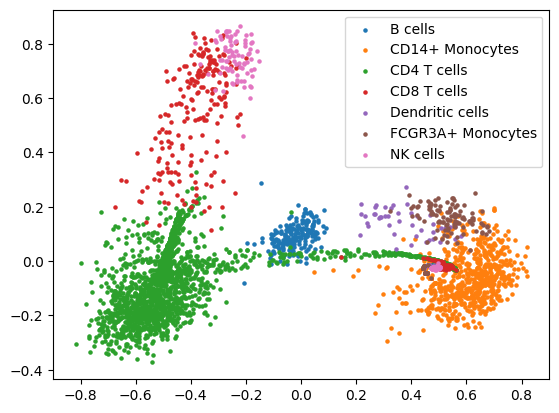

In [64]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
# run PC jointly:
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=pca.fit_transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['celltype'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_pc = np.concatenate((Xrna_integrated_pc,Yatac_subsamp_integrated_pc), axis=0)
for label in unique_labels:
    mask = (concat_labels == label)
    plt.scatter(concat_pc[mask, 0], concat_pc[mask, 1], s=5, label = label)
plt.legend(loc='best', shadow=False)


We can evaluate our alignment with label transfer accuracy, which determines how well a classifier extends from the original domain to the new domain:

In [68]:
from sklearn.neighbors import KNeighborsClassifier
def transfer_accuracy(domain1, domain2, type1, type2,n):
	"""
	Metric from UnionCom: "Label Transfer Accuracy"
	"""
	knn = KNeighborsClassifier(n_neighbors=n)
	knn.fit(domain2, type2)
	type1_predict = knn.predict(domain1)
	count = 0
	for label1, label2 in zip(type1_predict, type1):
		if label1 == label2:
			count += 1
	return count / len(type1)

In [69]:
transfer_accuracy(Xrna_integrated,Yatac_subsamp_integrated,rna['celltype'],atac_mod['celltype'],5)

0.5367677606979643